Loaded: /content/Microsoft_stock_data.xlsx | shape: (9958, 6)


,Date,Close,High,Low,Open,Volume
0,1986-03-13,0.059500,0.062157,0.054188,0.054188,1031788800
1,1986-03-14,0.061625,0.062688,0.059500,0.059500,308160000
2,1986-03-17,0.062688,0.063219,0.061625,0.061625,133171200
3,1986-03-18,0.061093,0.063219,0.060562,0.062688,67766400
4,1986-03-19,0.060031,0.061625,0.059500,0.061093,47894400



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9958 entries, 0 to 9957
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      9958 non-null   datetime64[ns]
 1   Close     9958 non-null   float64       
 2   High      9958 non-null   float64       
 3   Low       9958 non-null   float64       
 4   Open      9958 non-null   float64       
 5   Volume    9958 non-null   int64         
 6   year      9958 non-null   int32         
 7   month     9958 non-null   int32         
 8   day       9958 non-null   int32         
 9   iso_week  9958 non-null   UInt32        
 10  iso_day   9958 non-null   UInt32        
dtypes: UInt32(2), datetime64[ns](1), float64(4), int32(3), int64(1)
memory usage: 680.9 KB


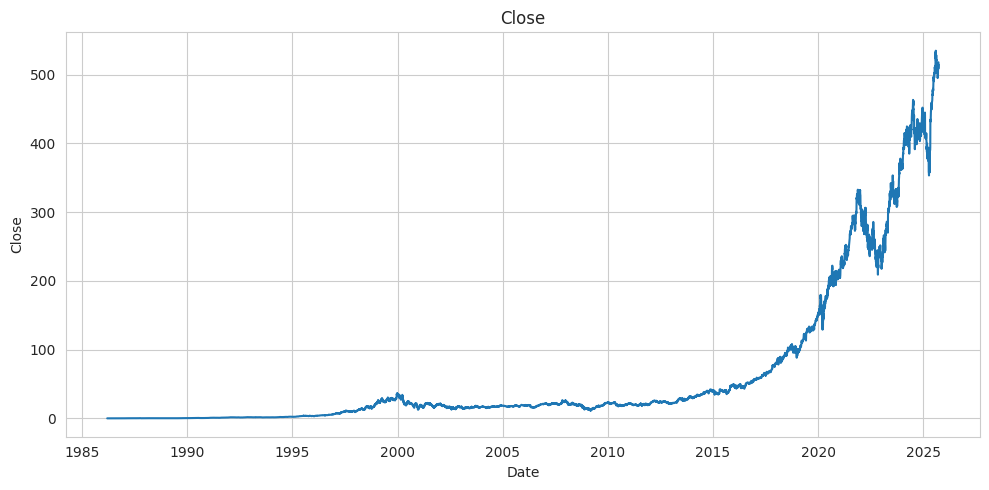

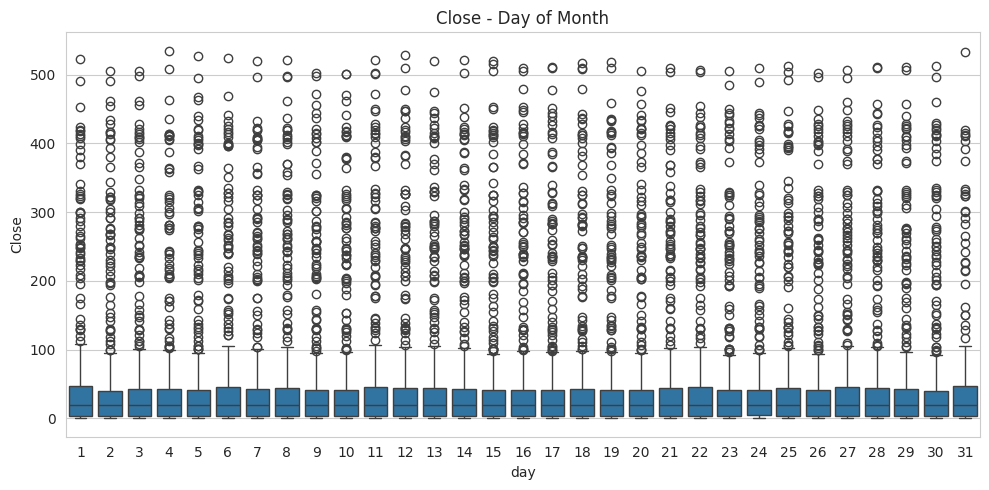

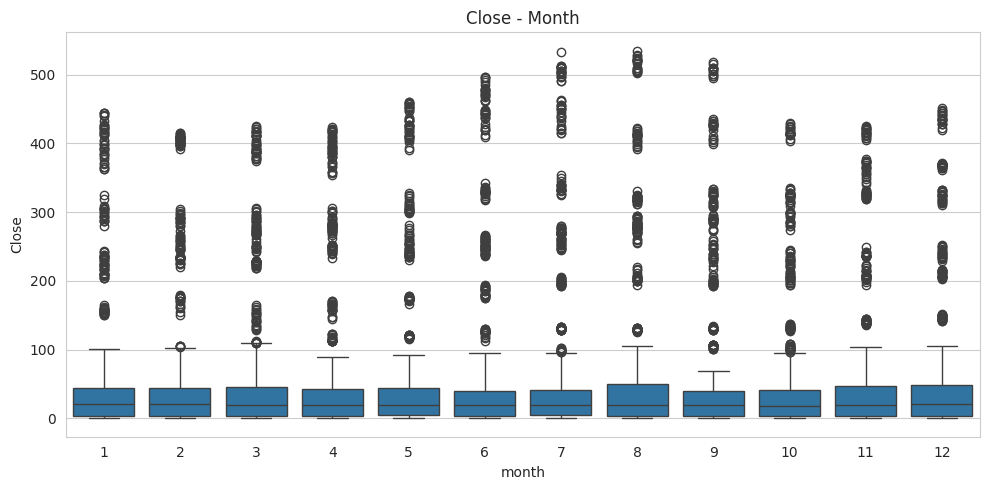

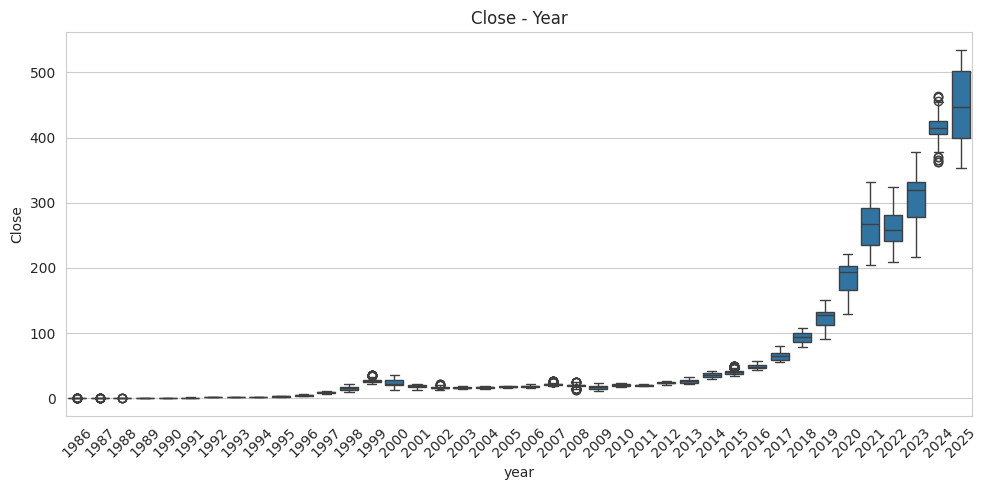

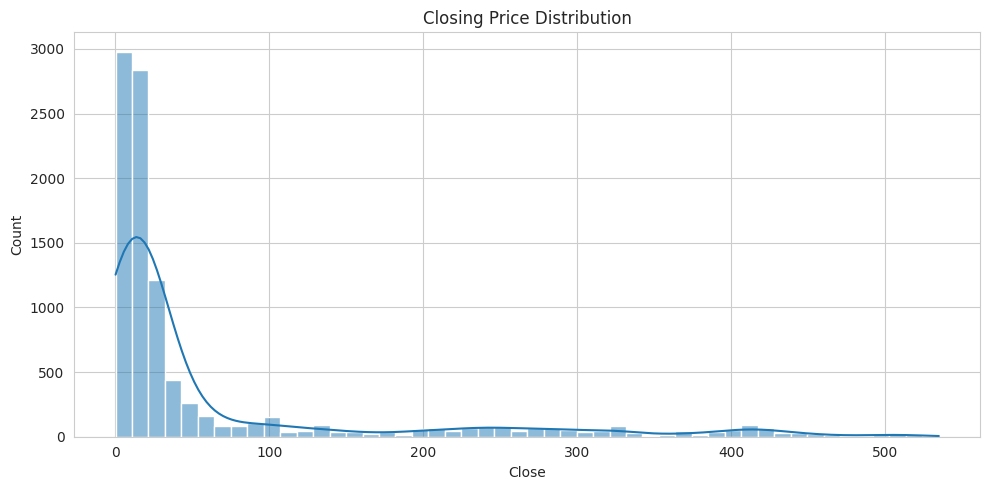

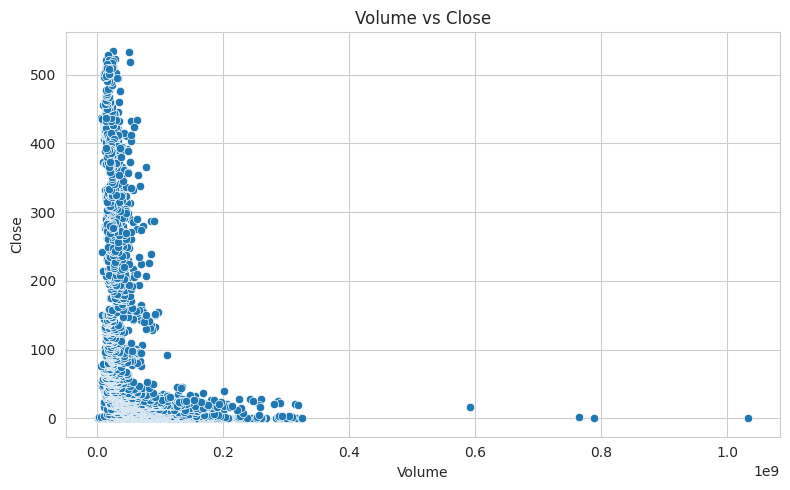

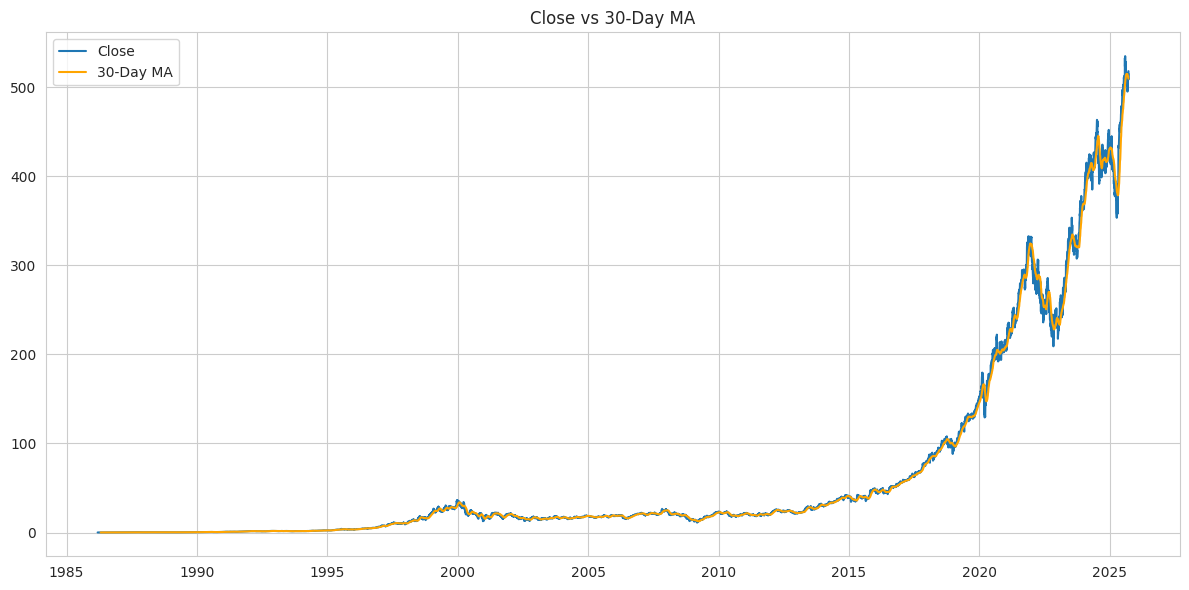

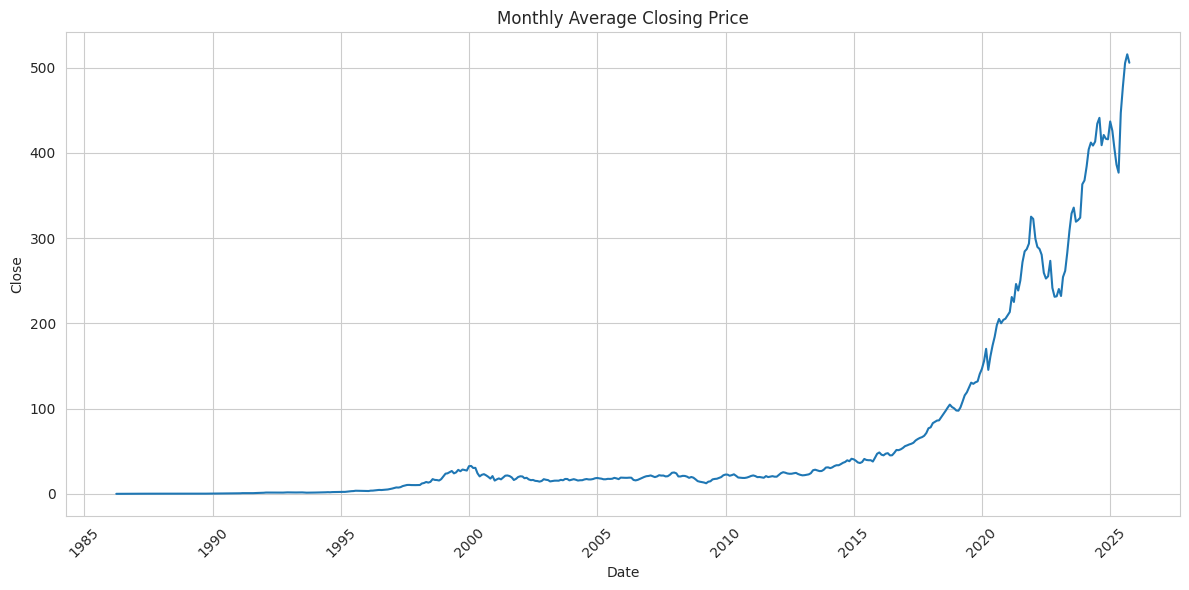

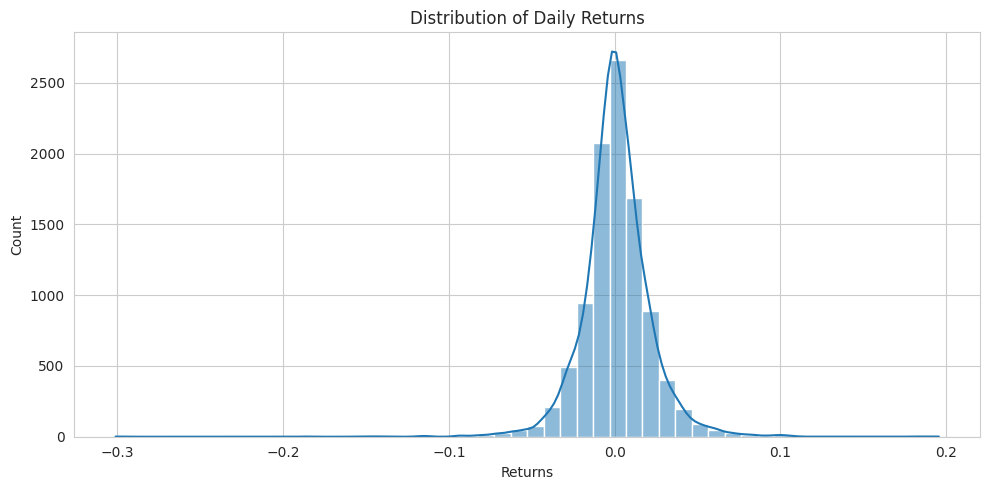

Inferred frequency: None
Number of missing business days: 354
Examples of missing business dates: DatetimeIndex(['1986-03-28', '1986-05-26', '1986-07-04', '1986-09-01',
               '1986-11-27'],
              dtype='datetime64[ns]', freq=None)

Null values per column after reindexing:
Close       354
High        354
Low         354
Open        354
Volume      354
year        354
month       354
day         354
iso_week    354
iso_day     354
MA_30       383
Returns     355
dtype: int64

Null values after forward-fill:
Close        0
High         0
Low          0
Open         0
Volume       0
year         0
month        0
day          0
iso_week     0
iso_day      0
MA_30       30
Returns      1
dtype: int64
Inferred frequency after reindex: B

ADF Statistic: 4.621093
p-value: 1.000000
Critical Value (1%): -3.430987
Critical Value (5%): -2.861821
Critical Value (10%): -2.566920
❌ The series is NOT stationary (do not reject H0). Try differencing.
After 1st difference p-value: 0.00000

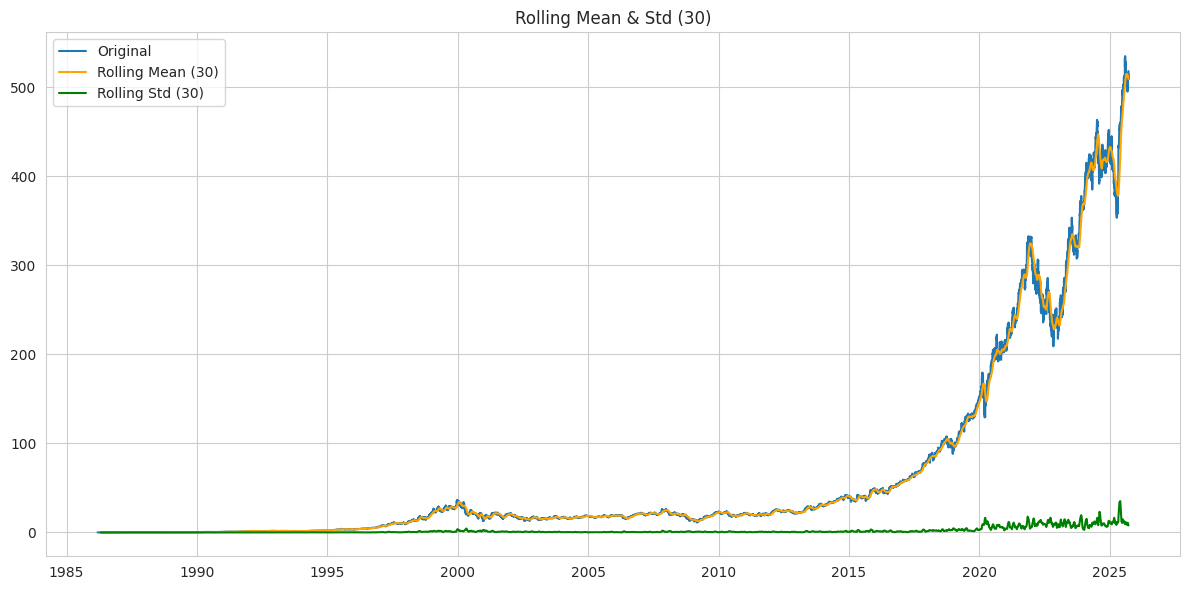

In [5]:
%matplotlib inline
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import time
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import plotly.graph_objects as go

sns.set_style("whitegrid")
np.random.seed(42)

# ---- Load dataset (try multiple likely paths) ----
possible_paths = ["/content/Microsoft_stock_data.xlsx"]
for p in possible_paths:
    if os.path.exists(p):
        url = p
        break
else:
    raise FileNotFoundError(f"Could not find the Excel file. Checked: {possible_paths}")

df = pd.read_excel(url)
print("Loaded:", url, "| shape:", df.shape)
display(df.head())

# ---- Basic preprocessing ----
# Ensure Date is datetime and Close is numeric
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

# Extract date parts (isocalendar returns a DataFrame-like object)
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
iso = df['Date'].dt.isocalendar()
# use bracket indexing for compatibility across pandas versions
df['iso_week'] = iso['week']
df['iso_day'] = iso['day']

# Quick info
print()
df.info()

# ---- EDA plots (kept similar but robustified) ----
plt.figure(figsize=(10,5))
sns.lineplot(data=df, x='Date', y='Close')
plt.title('Close')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='day', y='Close')
plt.title('Close - Day of Month')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='month', y='Close')
plt.title('Close - Month')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='year', y='Close')
plt.title('Close - Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(df['Close'].dropna(), bins=50, kde=True)
plt.title('Closing Price Distribution')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='Volume', y='Close')
plt.title('Volume vs Close')
plt.tight_layout()
plt.show()

# 30-day moving average overlay
df['MA_30'] = df['Close'].rolling(window=30).mean()
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label='Close')
plt.plot(df['Date'], df['MA_30'], label='30-Day MA', color='orange')
plt.title('Close vs 30-Day MA')
plt.legend()
plt.tight_layout()
plt.show()

# Candlestick (plotly)
fig = go.Figure(data=[go.Candlestick(
    x=df['Date'],
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close']
)])
fig.update_layout(title='Candlestick Chart', xaxis_title='Date', yaxis_title='Price')
fig.show()

# Monthly average (resample by month for robust ordering)
monthly_avg = df.set_index('Date').resample('M')['Close'].mean().reset_index()
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_avg, x='Date', y='Close')
plt.xticks(rotation=45)
plt.title('Monthly Average Closing Price')
plt.tight_layout()
plt.show()

# Daily returns
df['Returns'] = df['Close'].pct_change()
plt.figure(figsize=(10,5))
sns.histplot(df['Returns'].dropna(), bins=50, kde=True)
plt.title('Distribution of Daily Returns')
plt.tight_layout()
plt.show()

# ---- Indexing & frequency checks ----
# Sort, drop duplicate dates, set index
df = df.sort_values('Date').drop_duplicates(subset='Date').reset_index(drop=True)
df = df.set_index('Date')

freq = pd.infer_freq(df.index)
print("Inferred frequency:", freq)

# Check business-day completeness
business_days = pd.date_range(start=df.index.min(), end=df.index.max(), freq='B')
missing_bdays = business_days.difference(df.index)
print("Number of missing business days:", len(missing_bdays))
if len(missing_bdays) > 0:
    print("Examples of missing business dates:", missing_bdays[:5])

# Reindex to business days and forward-fill (only for Close here)
df_bday = df.reindex(business_days)
print("\nNull values per column after reindexing:")
print(df_bday.isna().sum())

df_bday.fillna(method='ffill', inplace=True)
print("\nNull values after forward-fill:")
print(df_bday.isna().sum())

df_bday.index.name = 'Date'
df_bday = df_bday[['Close']]

freq = pd.infer_freq(df_bday.index)
print("Inferred frequency after reindex:", freq)

# ---- Stationarity test (ADF) ----
serie = df_bday['Close'].dropna()
result = adfuller(serie)
print("\nADF Statistic: {:.6f}".format(result[0]))
print("p-value: {:.6f}".format(result[1]))
for key, value in result[4].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

if result[1] < 0.05:
    print("✅ The series is stationary (reject H0)")
else:
    print("❌ The series is NOT stationary (do not reject H0). Try differencing.")
    # quick check after 1st difference
    serie_diff = serie.diff().dropna()
    res_diff = adfuller(serie_diff)
    print("After 1st difference p-value: {:.6f}".format(res_diff[1]))

# Plot rolling mean/std
rolmean = serie.rolling(window=30).mean()
rolstd = serie.rolling(window=30).std()

plt.figure(figsize=(12,6))
plt.plot(serie, label='Original')
plt.plot(rolmean, label='Rolling Mean (30)', color='orange')
plt.plot(rolstd, label='Rolling Std (30)', color='green')
plt.legend(loc='best')
plt.title('Rolling Mean & Std (30)')
plt.tight_layout()
plt.show()

df_bday shape: (10312, 1)


,Close
Date,
1986-03-13,0.059500
1986-03-14,0.061625
1986-03-17,0.062688
1986-03-18,0.061093
1986-03-19,0.060031


,Close
Date,
2025-09-15,515.359985
2025-09-16,509.040009
2025-09-17,510.019989
2025-09-18,508.450012
2025-09-19,517.929993


              Close
count  10312.000000
mean      63.580829
std      109.570897
min        0.055250
25%        3.760450
50%       19.404536
75%       44.017749
max      534.760925


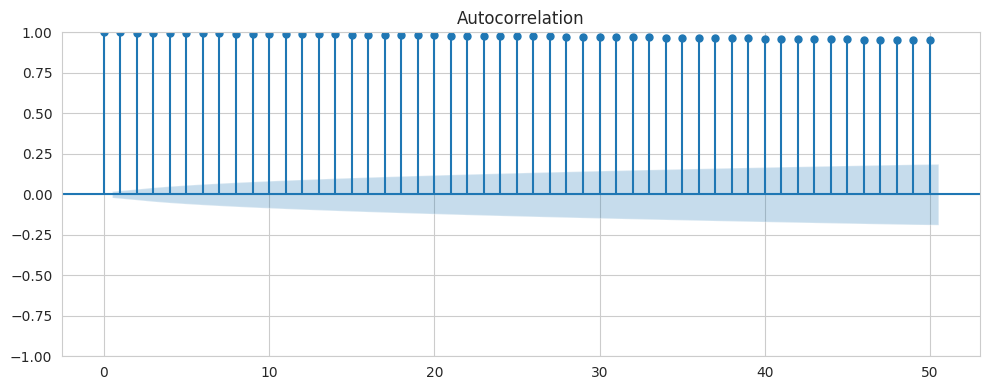

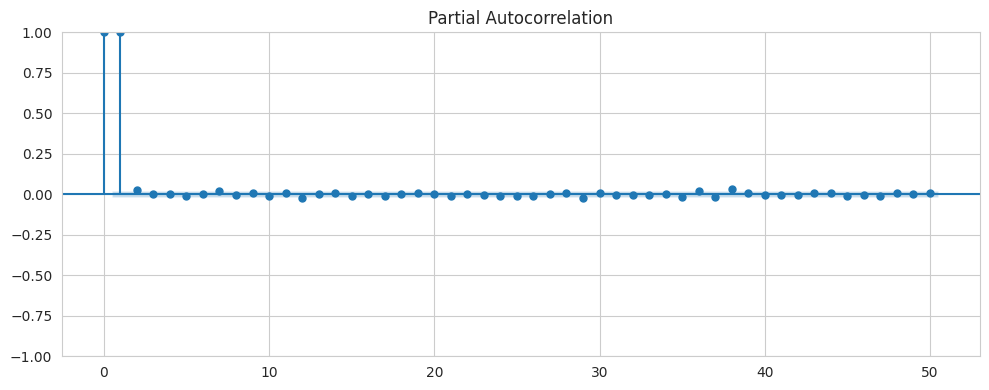

In [6]:
# Quick checks after preprocessing
print("df_bday shape:", df_bday.shape)
display(df_bday.head())
display(df_bday.tail())
print(df_bday.describe())

# Optional: show ACF/PACF to help with ARIMA order selection
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(10,4))
plot_acf(df_bday['Close'].dropna(), lags=50, ax=plt.gca())
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plot_pacf(df_bday['Close'].dropna(), lags=50, ax=plt.gca(), method='ywm')
plt.tight_layout(); plt.show()


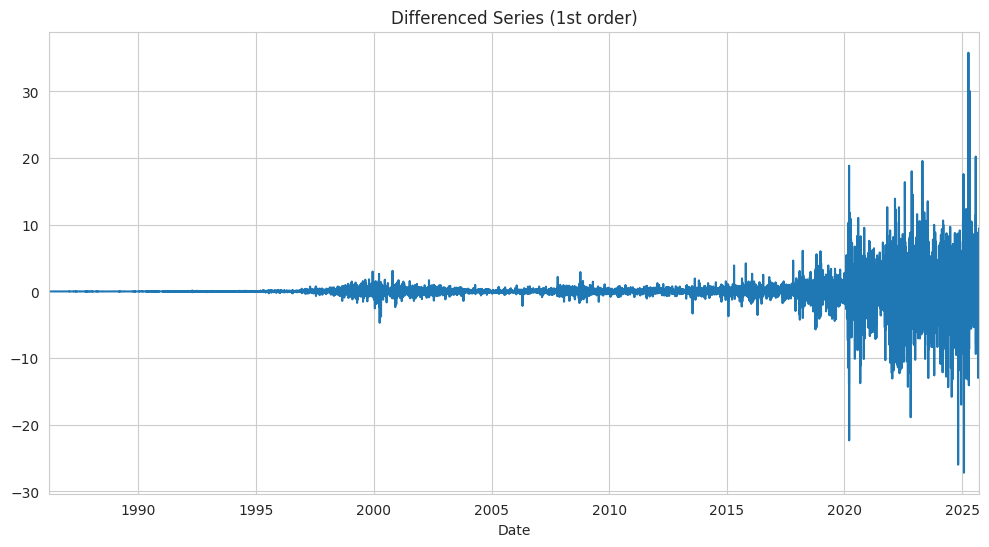

ADF Statistic (Differenced): -16.5153
p-value: 0.0000
✅ Stationary
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                10282
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -21427.190
Date:                Fri, 03 Oct 2025   AIC                          42860.381
Time:                        19:41:28   BIC                          42882.095
Sample:                    03-13-1986   HQIC                         42867.721
                         - 08-08-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2395      0.040      6.059      0.000       0.162       0.317
ma.L1         -0.3181      0.039     -8.155      0.000      -0.3

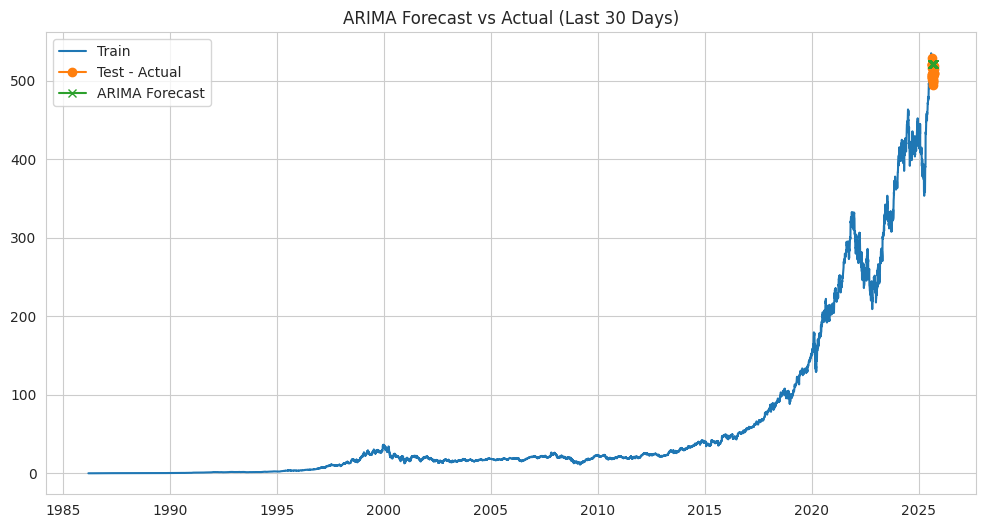

Epoch 1/30
639/639 ━━━━━━━━━━━━━━━━━━━━ 38s 52ms/step - loss: 0.0034 - val_loss: 6.6553e-04
Epoch 2/30
639/639 ━━━━━━━━━━━━━━━━━━━━ 40s 62ms/step - loss: 6.7032e-04 - val_loss: 0.0020
Epoch 3/30
639/639 ━━━━━━━━━━━━━━━━━━━━ 31s 48ms/step - loss: 5.1488e-04 - val_loss: 0.0022
Epoch 4/30
639/639 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - loss: 5.7711e-04 - val_loss: 1.8679e-04
Epoch 5/30
639/639 ━━━━━━━━━━━━━━━━━━━━ 32s 50ms/step - loss: 5.2566e-04 - val_loss: 0.0124
Epoch 6/30
639/639 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - loss: 5.2200e-04 - val_loss: 0.0059
Epoch 7/30
639/639 ━━━━━━━━━━━━━━━━━━━━ 31s 48ms/step - loss: 4.9592e-04 - val_loss: 0.0022
Epoch 8/30
639/639 ━━━━━━━━━━━━━━━━━━━━ 33s 52ms/step - loss: 4.8551e-04 - val_loss: 6.7224e-04
Epoch 9/30
639/639 ━━━━━━━━━━━━━━━━━━━━ 31s 48ms/step - loss: 4.9174e-04 - val_loss: 0.0022
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step

LSTM Metrics -> RMSE: 7.3078, MAPE: 1.16%


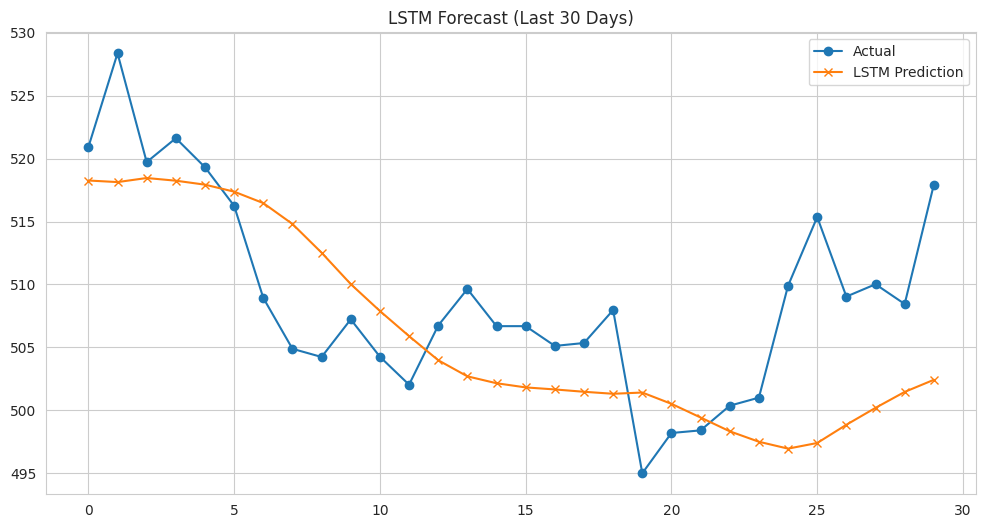


Performance Comparison:


,RMSE,MAPE(%)
Model,,
ARIMA,14.487072,2.524809
LSTM,7.307790,1.162032


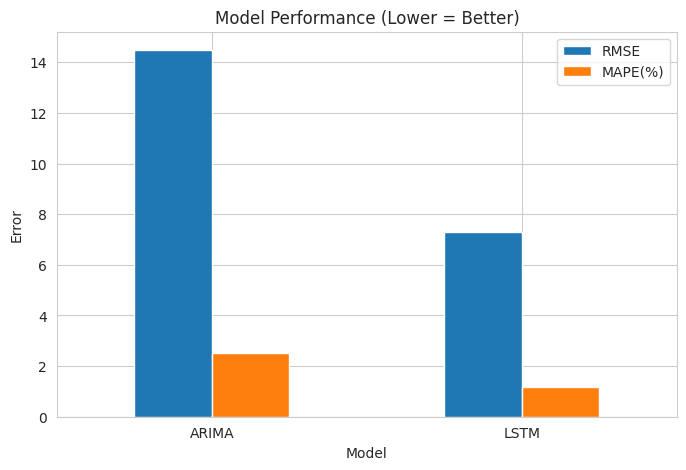

In [9]:
# ---- Differenced series for stationarity check ----
df_bday['Close_diff'] = df_bday['Close'].diff()
df_bday['Close_diff'].dropna().plot(figsize=(12,6), title='Differenced Series (1st order)')
plt.show()

resultado2 = adfuller(df_bday['Close_diff'].dropna())
print(f"ADF Statistic (Differenced): {resultado2[0]:.4f}")
print(f"p-value: {resultado2[1]:.4f}")
print("✅ Stationary" if resultado2[1] < 0.05 else "❌ Still not stationary")

# ---- ARIMA Model ----
train_size = len(df_bday) - 30
train, test = df_bday['Close'][:train_size], df_bday['Close'][train_size:]

model = ARIMA(train, order=(1,1,1))
result = model.fit()
print(result.summary())

# Forecast last 30 days
forecast = result.get_forecast(steps=30)
y_pred_arima = forecast.predicted_mean
y_true_arima = test

# Metrics
mse_arima = mean_squared_error(y_true_arima, y_pred_arima)
rmse_arima = np.sqrt(mse_arima)
mae_arima = mean_absolute_error(y_true_arima, y_pred_arima)
mape_arima = np.mean(np.abs((y_true_arima - y_pred_arima) / y_true_arima)) * 100

print(f"\nARIMA Metrics -> RMSE: {rmse_arima:.4f}, MAPE: {mape_arima:.2f}%")

# Plot ARIMA test forecast
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test - Actual", marker='o')
plt.plot(test.index, y_pred_arima, label="ARIMA Forecast", marker='x')
plt.legend(); plt.title("ARIMA Forecast vs Actual (Last 30 Days)")
plt.show()


# ---- LSTM Model ----
# Scale
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_bday[['Close']])

seq_len = 60
X, y = [], []
for i in range(seq_len, len(scaled_data)):
    X.append(scaled_data[i-seq_len:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split train/test
X_train, y_train = X[:-30], y[:-30]
X_test, y_test = X[-30:], y[-30:]

# Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], 1)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=30, batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# Predictions
y_pred_lstm = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_inv = scaler.inverse_transform(y_pred_lstm)

# Metrics
mse_lstm = mean_squared_error(y_test_inv, y_pred_inv)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_test_inv, y_pred_inv)
mape_lstm = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print(f"\nLSTM Metrics -> RMSE: {rmse_lstm:.4f}, MAPE: {mape_lstm:.2f}%")

# Plot
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual', marker='o')
plt.plot(y_pred_inv, label='LSTM Prediction', marker='x')
plt.title("LSTM Forecast (Last 30 Days)")
plt.legend(); plt.show()

# ---- Comparison ----
results = pd.DataFrame([
    {"Model": "ARIMA", "RMSE": rmse_arima, "MAPE(%)": mape_arima},
    {"Model": "LSTM",  "RMSE": rmse_lstm,  "MAPE(%)": mape_lstm}
]).set_index("Model")

print("\nPerformance Comparison:")
display(results)

results.plot(kind='bar', figsize=(8,5))
plt.title("Model Performance (Lower = Better)")
plt.ylabel("Error")
plt.xticks(rotation=0)
plt.show()

In [10]:
from tqdm import tqdm

def rolling_window_arima(series, window=365, forecast_horizon=1, order=(1,1,1)):
    errors_rmse, errors_mape = [], []
    series = series.dropna()

    for i in tqdm(range(window, len(series) - forecast_horizon)):
        train = series[i-window:i]
        test = series[i:i+forecast_horizon]

        try:
            model = ARIMA(train, order=order)
            result = model.fit()
            forecast = result.forecast(steps=forecast_horizon)

            rmse = np.sqrt(mean_squared_error(test, forecast))
            mape = np.mean(np.abs((test - forecast) / test)) * 100
            errors_rmse.append(rmse)
            errors_mape.append(mape)
        except:
            continue

    return np.mean(errors_rmse), np.mean(errors_mape)

# Run ARIMA rolling evaluation
arima_rmse_rw, arima_mape_rw = rolling_window_arima(df_bday['Close'], window=365, forecast_horizon=1)
print(f"Rolling Window ARIMA -> RMSE: {arima_rmse_rw:.4f}, MAPE: {arima_mape_rw:.2f}%")


100%|██████████| 9946/9946 [35:59<00:00,  4.61it/s]

Rolling Window ARIMA -> RMSE: 0.7681, MAPE: 1.38%


In [11]:
def rolling_window_lstm(series, window=180, forecast_horizon=1, seq_len=60, step=20):
    errors_rmse, errors_mape = [], []
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(series.values.reshape(-1,1))

    for i in tqdm(range(window, len(series) - forecast_horizon, step)):
        train = scaled[i-window:i]
        test = scaled[i:i+forecast_horizon]

        # Prepare sequences
        X, y = [], []
        for j in range(seq_len, len(train)):
            X.append(train[j-seq_len:j, 0])
            y.append(train[j, 0])
        X, y = np.array(X), np.array(y)
        X = X.reshape((X.shape[0], X.shape[1], 1))

        # Build simple LSTM
        model = Sequential([
            LSTM(32, input_shape=(seq_len, 1)),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        model.fit(X, y, epochs=3, batch_size=16, verbose=0)  # light training

        # Forecast
        last_seq = train[-seq_len:].reshape((1, seq_len, 1))
        pred = model.predict(last_seq, verbose=0)[0,0]
        pred = scaler.inverse_transform([[pred]])[0,0]
        actual = series.iloc[i]

        rmse = np.sqrt(mean_squared_error([actual], [pred]))
        mape = np.mean(np.abs((actual - pred) / actual)) * 100
        errors_rmse.append(rmse)
        errors_mape.append(mape)

    return np.mean(errors_rmse), np.mean(errors_mape)

# Run LSTM rolling evaluation (this will take longer)
lstm_rmse_rw, lstm_mape_rw = rolling_window_lstm(df_bday['Close'], window=180, forecast_horizon=1, step=20)
print(f"Rolling Window LSTM -> RMSE: {lstm_rmse_rw:.4f}, MAPE: {lstm_mape_rw:.2f}%")


100%|██████████| 507/507 [24:39<00:00,  2.92s/it]

Rolling Window LSTM -> RMSE: 7.8808, MAPE: 40.65%



Final Comparison (Static vs Rolling Window):


,RMSE,MAPE(%)
Model,,
ARIMA (Static),14.487072,2.524809
LSTM (Static),7.307790,1.162032
ARIMA (Rolling),0.768139,1.379800
LSTM (Rolling),7.880846,40.645932


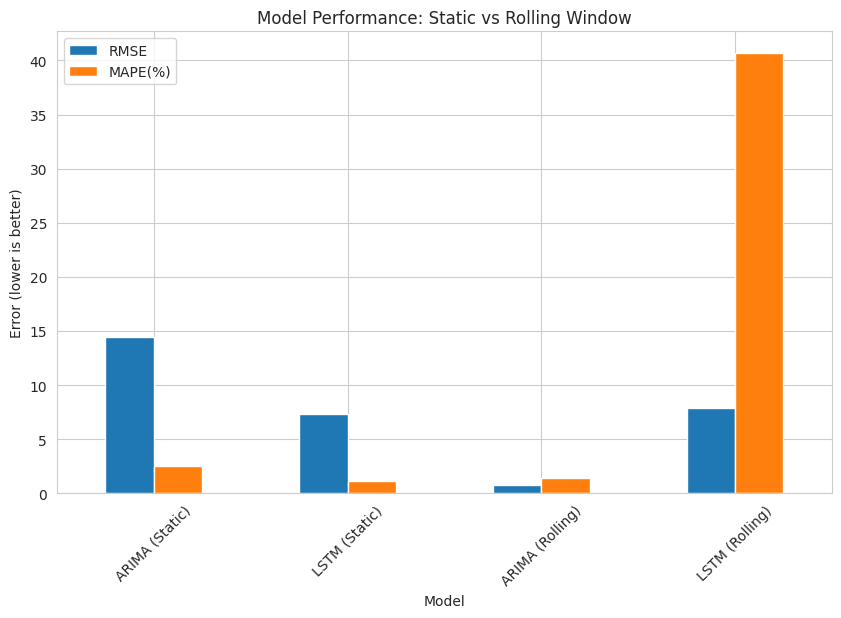

In [12]:
# Static split results from before
static_results = pd.DataFrame([
    {"Model": "ARIMA (Static)", "RMSE": rmse_arima, "MAPE(%)": mape_arima},
    {"Model": "LSTM (Static)",  "RMSE": rmse_lstm,  "MAPE(%)": mape_lstm}
])

# Rolling results
rolling_results = pd.DataFrame([
    {"Model": "ARIMA (Rolling)", "RMSE": arima_rmse_rw, "MAPE(%)": arima_mape_rw},
    {"Model": "LSTM (Rolling)",  "RMSE": lstm_rmse_rw,  "MAPE(%)": lstm_mape_rw}
])

# Combine
final_results = pd.concat([static_results, rolling_results]).set_index("Model")

print("\nFinal Comparison (Static vs Rolling Window):")
display(final_results)

# Plot
final_results.plot(kind='bar', figsize=(10,6))
plt.title("Model Performance: Static vs Rolling Window")
plt.ylabel("Error (lower is better)")
plt.xticks(rotation=45)
plt.show()
